In [65]:
# pandas_datareader 0.5.0
# pandas 0.20.3
# sci-kit 0.19.1
import PublicData as PD
import itertools
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix

def precision_recall_plot(y_true, y_probas):
    precision, recall, threshold = precision_recall_curve(y_true, y_probas)
    f, ax = plt.subplots(figsize=(8,8))
    ax.step(recall, precision, where='post', color='blue')
    ax.fill_between(recall, precision, step='post',
                    alpha=0.25, color='blue')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim((0.0, 1.05))
    ax.set_xlim((0.0, 1.0))
    ax.set_title('Precision & Recall')
    ax.grid()
    return f, ax

def roc_plot(y_true, y_probas):
    fpr, tpr, threshold = roc_curve(y_true, y_probas)
    f, ax = plt.subplots(figsize=(8,8))
    ax.plot(fpr, tpr)
    ax.grid()
    ax.set_title('ROC')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    return f, ax

def plot_confusion_matrix(y_true, y_pred):
    classes = list(set(y_true))
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_sum = conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix = conf_matrix.astype('float') / conf_matrix_sum
    
    f, ax = plt.subplots(figsize=(6,6))
    ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title("Confusion Matrix")

    ax.xaxis.set_ticks(classes)
    ax.yaxis.set_ticks(classes)

    fmt = '.2f'
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="black", fontsize=14)

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return f, ax


In [59]:
# fetch timeseries of SPY data
spy_data = PD.get_timeseries_data('SPY', 
                                  start_dt = dt.datetime(2003, 12, 31),
                                  end_dt = dt.datetime(2017, 12, 31))

spy_data['return_t0'] = spy_data['close'].pct_change()  # return today
spy_data['return_t5'] = spy_data['close'].pct_change(5)  # return over last week
spy_data['return_t20'] = spy_data['close'].pct_change(20)  # return over last month
spy_data['return_t60'] = spy_data['close'].pct_change(60)  # return over last quarter
spy_data['vol_t5'] = spy_data['return_t0'].rolling(5).std().multiply(np.sqrt(252))  # rolling 5 day std, annualized
spy_data['vol_t20'] = spy_data['return_t0'].rolling(20).std().multiply(np.sqrt(252))  # rolling 20 day std, annualized
spy_data['vol_t60'] = spy_data['return_t0'].rolling(60).std().multiply(np.sqrt(252))  # rolling 60 day std, annualized

# create the target, the return over the next 5 days
tgt_return = spy_data['close'].shift(-5).divide(spy_data['close']).subtract(1)
tgt_return_log = np.log(1+tgt_return)
# add the 'turn on' class for returns greater than or equal 20bps
tgt_class = np.where(tgt_return_log >= 0.0025, 1, 0)

spy_data['target'] = tgt_class
spy_data = spy_data.dropna()

# split into training and test
x_cols = ['return_t0','return_t5',
          'return_t20','return_t60',
          'vol_t5', 'vol_t20', 'vol_t60']
train_idx = spy_data.index[:1000]
test_idx = spy_data.index[1000:]
y_test = spy_data.loc[test_idx, 'target'].values
x_test = spy_data.loc[test_idx, x_cols].values

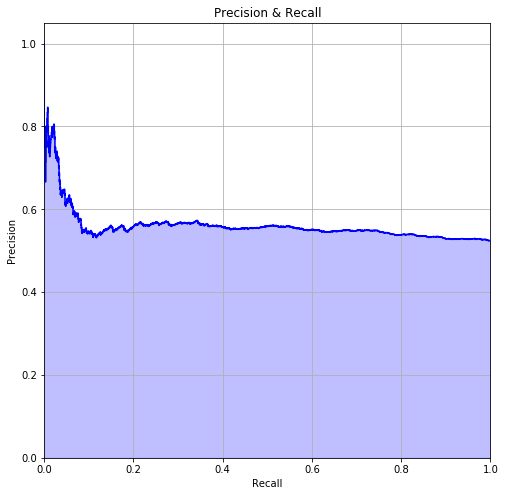

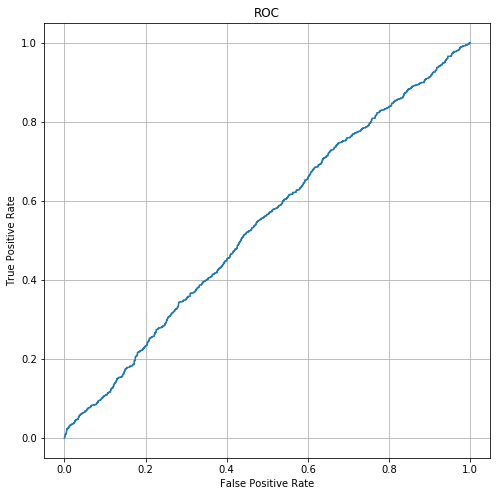

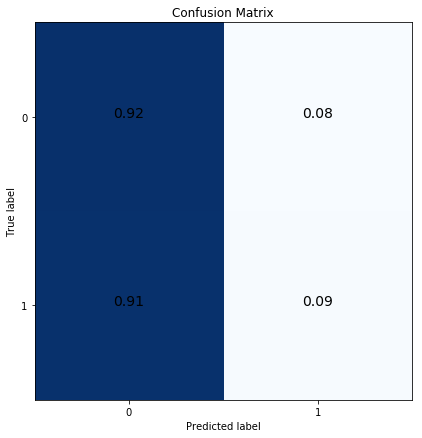

In [67]:
# Train a mlp ann for classification
params = {'hidden_layer_sizes' : [(100,), (100,3), (100,4)],
          'alpha' : [0.1, 0.01, 0.001, 0.0001],
          }
# fit
mlp_clf = GridSearchCV(MLPClassifier(), params, scoring='f1')
mlp_clf.fit(spy_data.loc[train_idx, x_cols].values,
            spy_data.loc[train_idx, 'target'].values)
# predict
mlp_clf_pred = mlp_clf.predict(x_test)
mlp_clf_pred_proba = mlp_clf.predict_proba(x_test)
# plot precision and recall
mlp_clf_pr_f, mlp_clf_pr_ax = precision_recall_plot(y_test,
                                                    mlp_clf_pred_proba[:, 1])
# plot roc curve
mlp_clf_roc_f, mlp_clf_roc_ax = roc_plot(y_test,
                                         mlp_clf_pred_proba[:, 1])

mlp_clf_cm_f, mlp_clf_cm_ax = plot_confusion_matrix(y_test,
                                                    mlp_clf_pred)

plt.show()
plt.close('all')

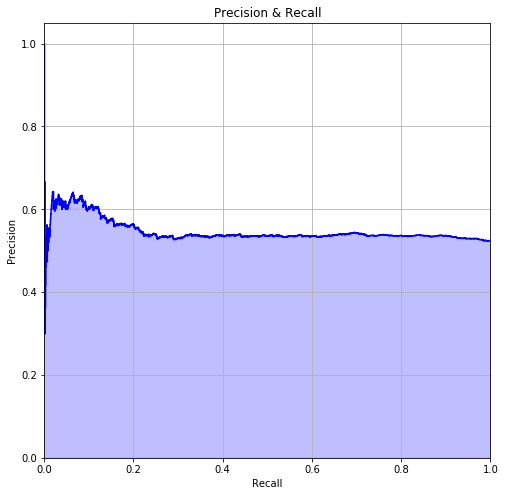

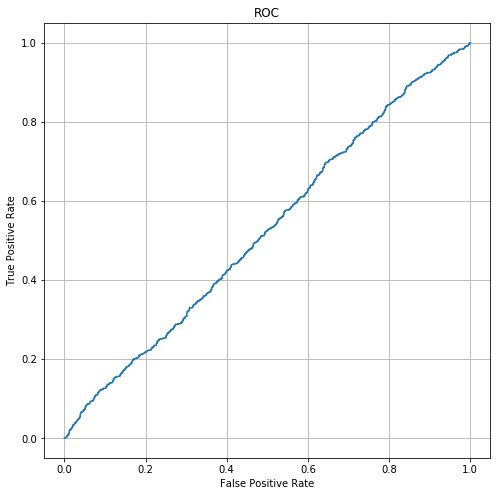

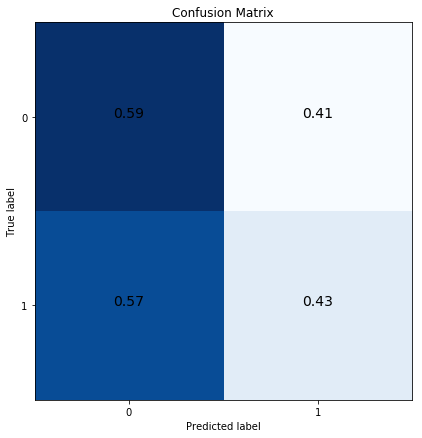

In [66]:
# Train a KNeighborsClassifier for classification
params = {'n_neighbors' : [5, 10, 20, 60],
          'weights' : ['uniform', 'distance'],
          'leaf_size' : [10, 30, 50],
          'p' : [2, 3, 4]
          }
# fit
knc_clf = GridSearchCV(KNeighborsClassifier(), params, scoring='f1')
knc_clf.fit(spy_data.loc[train_idx, x_cols].values,
            spy_data.loc[train_idx, 'target'].values)
# predict
knc_clf_pred = knc_clf.predict(x_test)
knc_clf_pred_proba = knc_clf.predict_proba(x_test)
# plot precision and recall
knc_clf_pr_f, knc_clf_pr_ax = precision_recall_plot(y_test,
                                                    knc_clf_pred_proba[:, 1])
# plot roc curve
knc_clf_roc_f, knc_clf_roc_ax = roc_plot(y_test,
                                         knc_clf_pred_proba[:, 1])

knc_clf_cm_f, knc_clf_cm_ax = plot_confusion_matrix(y_test,
                                                    knc_clf_pred)

plt.show()
plt.close('all')

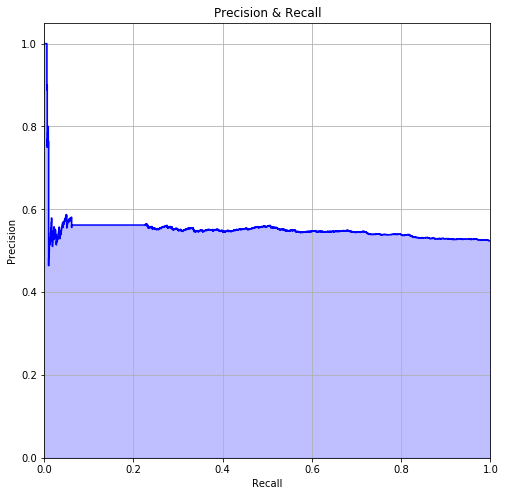

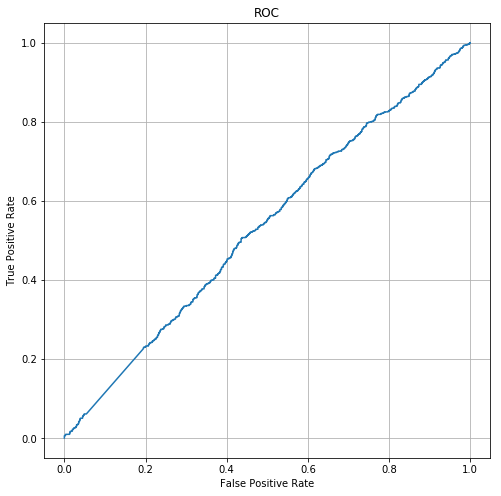

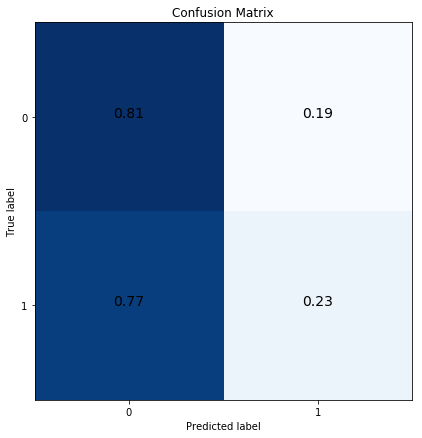

In [68]:
# Train a SVC for classification
params = {'C' : [10.0, 1.0, 0.1, 0.01],
          'kernel' : ['rbf', 'linear', 'sigmoid'],
          'probability' : [True]
          }
# fit
svc_clf = GridSearchCV(SVC(), params, scoring='f1')
svc_clf.fit(spy_data.loc[train_idx, x_cols].values,
            spy_data.loc[train_idx, 'target'].values)
# predict
svc_clf_pred = svc_clf.predict(x_test)
svc_clf_pred_proba = svc_clf.predict_proba(x_test)
# plot precision and recall
svc_clf_pr_f, svc_clf_pr_ax = precision_recall_plot(y_test,
                                                    svc_clf_pred_proba[:, 1])
# plot roc curve
svc_clf_roc_f, svc_clf_roc_ax = roc_plot(y_test,
                                         svc_clf_pred_proba[:, 1])

svc_clf_cm_f, svc_clf_cm_ax = plot_confusion_matrix(y_test,
                                                    svc_clf_pred)

plt.show()
plt.close('all')

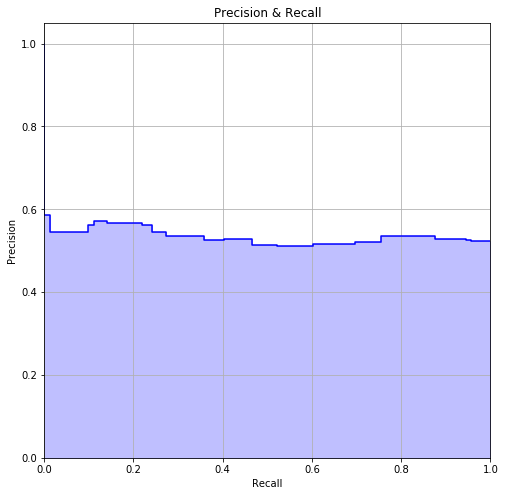

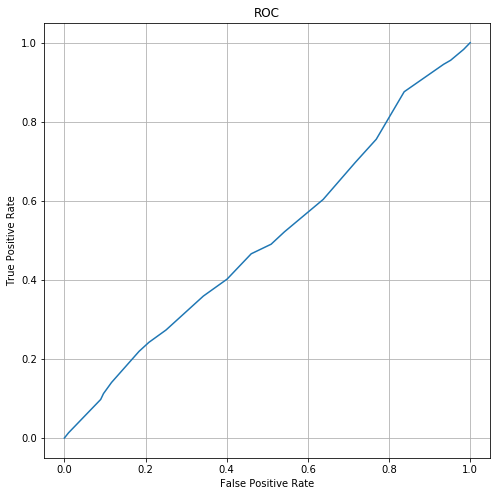

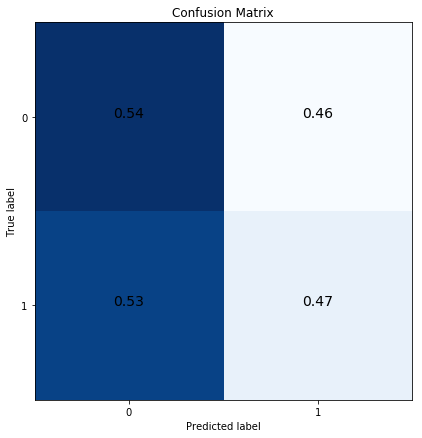

In [69]:
# Train a DecisionTreeClassifier for classification
params = {'criterion' : ['gini'],
          'max_depth' : [2, 5, 10, 20, None],
          'min_samples_split' : [0.01, 0.05, 0.1]
          }
# fit
dtc_clf = GridSearchCV(DecisionTreeClassifier(), params, scoring='f1')
dtc_clf.fit(spy_data.loc[train_idx, x_cols].values,
            spy_data.loc[train_idx, 'target'].values)
# predict
dtc_clf_pred = dtc_clf.predict(x_test)
dtc_clf_pred_proba = dtc_clf.predict_proba(x_test)
# plot precision and recall
dtc_clf_pr_f, dtc_clf_pr_ax = precision_recall_plot(y_test,
                                                    dtc_clf_pred_proba[:, 1])
# plot roc curve
dtc_clf_roc_f, dtc_clf_roc_ax = roc_plot(y_test,
                                         dtc_clf_pred_proba[:, 1])

dtc_clf_cm_f, dtc_clf_cm_ax = plot_confusion_matrix(y_test,
                                                    dtc_clf_pred)

plt.show()
plt.close('all')

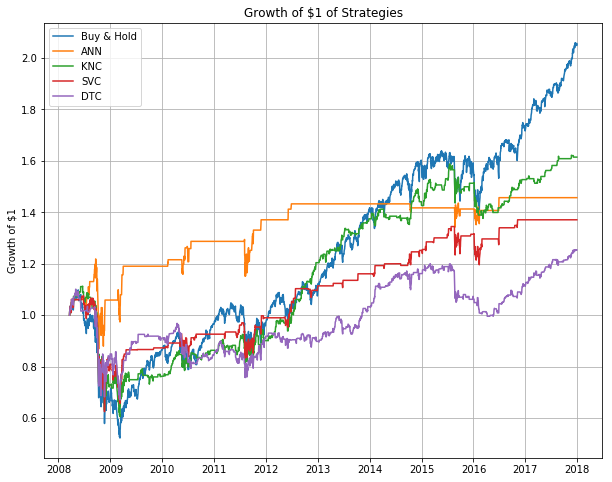

In [78]:
# plot the performance of the models
import pandas as pd
returns = spy_data.loc[test_idx, 'return_t0']
returns.iloc[0] = 0.0

wealthpaths = pd.DataFrame()
wealthpaths['Buy & Hold'] = returns.copy(deep=True)

wealthpaths['ANN'] = mlp_clf_pred
wealthpaths['ANN'] = wealthpaths['ANN'].shift(1).fillna(0.0)
wealthpaths['ANN'] = wealthpaths['ANN'].multiply(returns)

wealthpaths['KNC'] = knc_clf_pred
wealthpaths['KNC'] = wealthpaths['KNC'].shift(1).fillna(0.0)
wealthpaths['KNC'] = wealthpaths['KNC'].multiply(returns)

wealthpaths['SVC'] = svc_clf_pred
wealthpaths['SVC'] = wealthpaths['SVC'].shift(1).fillna(0.0)
wealthpaths['SVC'] = wealthpaths['SVC'].multiply(returns)

wealthpaths['DTC'] = dtc_clf_pred
wealthpaths['DTC'] = wealthpaths['DTC'].shift(1).fillna(0.0)
wealthpaths['DTC'] = wealthpaths['DTC'].multiply(returns)

wealthpaths = wealthpaths.add(1.0).cumprod()

f, ax = plt.subplots(figsize = (10, 8))
for col in wealthpaths:
    s = wealthpaths[col]
    ax.plot(s.index, s.values, label = col)

ax.grid()
ax.legend(loc='best')
ax.set_ylabel("Growth of $1")
ax.set_title("Growth of $1 of Strategies")
plt.show()
plt.close('all')

In [80]:
mean_return = wealthpaths.pct_change().mean()
mean_return = mean_return.multiply(252.0)

std_return = wealthpaths.pct_change().std()
std_return = std_return.multiply(np.sqrt(252))

sharpes = mean_return.divide(std_return)
sharpes

Buy & Hold    0.465146
ANN           0.370448
KNC           0.374472
SVC           0.280483
DTC           0.223091
dtype: float64